In [12]:
import sys
sys.path.append("/home/diego/python/convolution-kernels/")
sys.path.append("/home/diego/python/stochastic-processes/")
sys.path.append("/home/diego/python/utils/")

import matplotlib.pyplot as plt
import numpy as np

from kernel.fun import KernelFun
from processes.renewal_process import RenewalProcess
# from processes.gaussian_process import GaussianProcess
from processes.dichotomized_gaussian import DichotomizedGaussian
from signals import raw_autocorrelation
from sptr.sptr import SpikeTrain

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


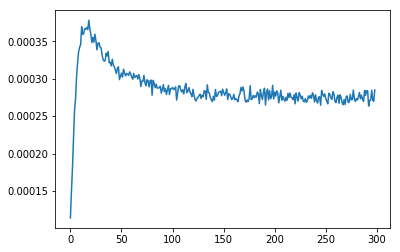

In [13]:
def double_exp(t, A, tr, td, t0):
    return A * tr * td / (td - tr) * (np.exp(-(t - t0) / td) - np.exp(-(t - t0) / tr))

dt = 1
n_trials = 10000
t = np.arange(0, 1000, dt)

b, A, tr, td, t0 = -4.5, 0.2, 5, 50, 12
t0 = 2

eta = KernelFun(double_exp, basis_kwargs=dict(A=np.array([A])), shared_kwargs=dict(tr=tr, td=td, t0=t0), 
            coefs=np.array([1]), support=[0, tr * td / (td - tr) + td * 7])
# eta = KernelFun(lambda t, A, td: A * np.exp(-t / td), basis_kwargs=dict(A=np.array([1])), 
#                 shared_kwargs=dict(td=td), 
#               coefs=np.array([1]), support=[0, td * 7])
rp = RenewalProcess(b, eta)

u, r, mask_spikes = rp.sample(t, shape=(n_trials,))
isi = SpikeTrain(t, mask_spikes).isi_distribution()

n_spikes = np.sum(mask_spikes, 0)
raw_autocor = np.mean(raw_autocorrelation(mask_spikes, biased=False), 1)
raw_autocor = raw_autocor[:300]

lam = np.mean(n_spikes) / (len(t) * 1)

fig, ax1 = plt.subplots()
ax1.plot(raw_autocor[1:])

(0, 200)

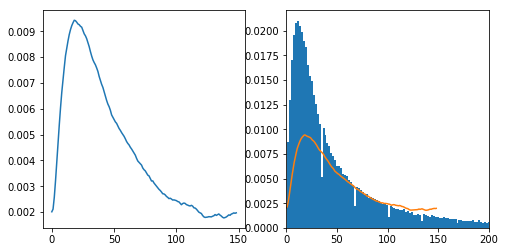

In [38]:
from signals import fourier_transform, fourier_transform_freqs, inv_fourier_transform

f = fourier_transform_freqs(raw_autocor, dt)
autocorr_fft = fourier_transform(raw_autocor[1:], dt) / f[1:]#np.fftraw_autocor[1:]
P0_fft = autocorr_fft / (1 + autocorr_fft)
P0 = inv_fourier_transform(P0_fft, dt, negative_times=False)
cum_P0 = 

fig, (ax1, ax2) = plt.subplots(figsize=(8, 4), ncols=2)
ax1.plot(P0)
ax2.hist(isi, density=True, bins=500);
ax2.plot(P0);
ax2.set_xlim(0, 200)

In [94]:
from scipy.special import erfinv
from scipy.stats import multivariate_normal
from processes.gaussian_process import GaussianProcess

from sptr.sptr import SpikeTrain

dt = 1
cov0 = 1e0
p = np.mean(n_spikes) / len(t)
dx = np.sqrt(cov0) * 2e-3
mus = np.arange(-20, 20, .1)
drho = 0.01
rho_gauss = np.arange(-1 + drho, 1, drho)

p_mu = []

for mu in mus:
    x = np.arange(-5 * np.sqrt(cov0), 5 * np.sqrt(cov0), dx) + mu
    gaussian_pdf = multivariate_normal.pdf(x, mean=mu, cov=cov0)
    p_mu.append(np.sum((1 - np.exp(-np.exp(x) * dt)) * gaussian_pdf * dx))

argmin = np.argmin(np.abs(p_mu - p))
mu = mus[argmin]

x = np.arange(-5 * np.sqrt(cov0), np.sqrt(cov0) * 5, dx) + mu
x2d = np.stack(np.meshgrid(x, x), 2)

rho_dg = []
for _rho_gauss in rho_gauss:
    cov_gauss = np.array([[cov0, cov0 * _rho_gauss], [cov0 * _rho_gauss, cov0]])
    bivariate_normal_pdf = multivariate_normal.pdf(x2d, mean=np.ones(2) * mu, cov=cov_gauss)
    rho_dg.append(np.sum(p_spike(x[:, None]) * p_spike(x[None, :]) * bivariate_normal_pdf * dx * dx))
rho_dg = np.array(rho_dg)

# autocov = np.zeros(len(raw_autocor))
error_rho = np.abs(raw_autocor[1:250, None] - rho_dg[None, :])
argmin = np.argmin(error_rho, 1)
autocov = cov0 * rho_gauss[argmin]
raw_autocorr_dg = rho_dg[argmin]
error_rho = np.abs(raw_autocor[1:250] - raw_autocorr_dg)
if np.all(error_rho / np.abs(raw_autocor[1:250]) < 1e-1):
    print('small error')
autocov[0] = cov0

fig, (ax1, ax2, ax3, ax4) = plt.subplots(figsize=(8, 4), ncols=4)
ax1.plot(mus, p_mu, '-')
ax2.plot(rho_gauss, rho_dg, '-')
ax3.plot(raw_autocorr_dg, '-')
ax4.plot(autocov, '-')

MemoryError: Unable to allocate 381. MiB for an array with shape (5000, 5000, 2) and data type float64

In [92]:
# autocov = 4e0 * np.exp(-np.arange(0, len(autocov), 1) / 20)
gp = GaussianProcess(mu=mu, autocov=autocov)
gp.set_t(t)

u = gp.sample(shape=(5000,))
x = 1 - np.exp(-np.exp(u) * dt) > np.random.rand(*u.shape)
gp_autocorr = np.mean(raw_autocorrelation(u, biased=False), 1) - mu**2
raw_autocor2 = np.mean(raw_autocorrelation(x, biased=False), 1) 

print(np.mean(u), np.mean((u - mu)**2), mu, cov0)
print(np.mean(np.sum(mask_spikes, 0)),  np.mean(np.sum(x, 0)))

fig, (ax1, ax2, ax3) = plt.subplots(figsize=(18, 4), nrows=3)
ax1.plot(u[:, 0])
ax2.plot(np.exp(u[:, 0]))
SpikeTrain(t, x[:, :1]).plot(ax=ax2, ms=0.7)

fig, (ax1, ax2) = plt.subplots(figsize=(8, 4), ncols=2)
ax1.plot(raw_autocor[1:350])
ax1.plot(raw_autocor2[1:350])
# ax1.set_ylim(-1e-5, 4e-4)
# ax1.set_ylim(3e-4, 1e-3)
ax2.plot(autocov[1:250])
ax2.plot(gp_autocorr[1:250])

LinAlgError: 3-th leading minor not positive definite